## Marketing Campaign Analysis using Uplift Modeling

Companies often utilize various approaches to entice customers. For instance, online educators might send emails with successful cases to potential students. E-commerce companies send push notifications to urge customers continue unfinished checkout process. Although monitoring key metrics such as conversion rate might be useful, there's one key problem that cannot be solved. **We cannot know whether the surge or plumment is the result of such campaign**. 

This type of question cannot be easily sold by simple machine learning models. Instead, we can turn to the idea of **uplift modeling** to actually get the key feature that results in such uplift.

### Types of Uplift Modeling

There are three types of moodels related to such topic.

<img src='pic/models.png' width=800>

* The **look-alike model** returns a probability that the customer is going to accomplish a target action. The term **looke-alike** tells the gist of the model. It looks for customers similar to the ones performing such action. Customers similar to those people will be more likely to accomplish the target action.

* The **response model** predicts whether or not the customer perform target actions given interaction between two parties. Such interactions are often termed **treatment** in the analysis. The data is composed of valid datapoints with interactions; some of which ultimately accomplish target actions, while others don't.

* The **uplift model** estimates the difference between treatment. That is, it subtracts the probability of performing target actions with and without treatment. Uplift modeling is preferred in such analysis as it compares with the baseline -- those without treatment effect. As such, we can know that, all else equal, how effective the marketing event is.

In the following notebook, we will utilize the package **scikit-uplift** to perform uplift modeling analysis.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [20]:
pdf = pd.read_csv('data/campaign.csv')
# pdf = pdf_train.copy()
pdf.shape

(687029, 196)

In [21]:
pdf.head()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


* There are 196 columns in the dataset

* The target variable is response_att - we have to predict whether the client will respond to the market mailing

* Audience is divided into 2 samples - test and control

* The dataset gives us basic information about the client, for example, his age, number of children

* There is also a lot of information about some groups of goods (it's necessary for searching insights) and a lot of statistical information for example the coefficients of variation of discounts or prices

In [22]:
gender_map = {'Ж': 0, 'М': 1}
group_map = {'test': 1, 'control': 0}
pdf['gender'] = pdf['gender'].map(gender_map)
pdf['group'] = pdf['group'].map(group_map)

## Check missing data

todo: 用比較好的方式清理 data,  現在先簡單處理

In [23]:
print('Number NA:', pdf.isna().sum().sum())
print('Amount of all values:', pdf.shape[0]*pdf.shape[1])
print('Missed Data Percentage:', round(100*pdf.isna().sum().sum()/(pdf.shape[0]*pdf.shape[1]), 2), '%')

Number NA: 25640556
Amount of all values: 134657684
Missed Data Percentage: 19.04 %


In [24]:
%%time

# dealing with missing data
pdf = pdf.fillna(np.nan)
pdf_col_list = list(pdf.columns)
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose = 1)
# imputer = KNNImputer(missing_values=np.nan, n_neighbors=3)
pdf = pd.DataFrame(imputer.fit_transform(pdf), columns=pdf_col_list)

print('Number NA:', pdf.isna().sum().sum())

Number NA: 0
CPU times: user 25.3 s, sys: 9.34 s, total: 34.7 s
Wall time: 48.1 s


## Outlier Manipulation

In [25]:
for col in tqdm(pdf.columns):
    pdf[col] = np.clip(pdf[col], a_min = np.nanpercentile(pdf[col], 1), a_max = np.nanpercentile(pdf[col], 99))

100%|██████████| 196/196 [00:03<00:00, 59.14it/s]


## Check correlation

todo: find heatmap trick

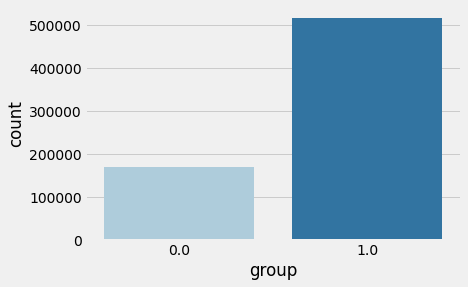

In [26]:
sns.countplot(x="group", data=pdf)
plt.show()

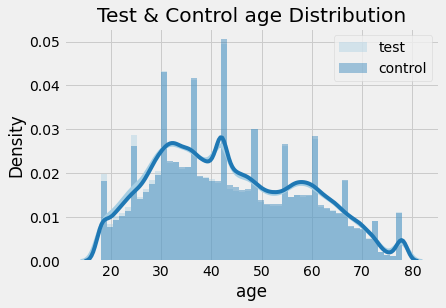

In [27]:
test = pdf[pdf['group'] == 0]

control = pdf[pdf['group'] == 1]

sns.distplot(test['age'], label='test')
sns.distplot(control['age'], label='control')
plt.title('Test & Control age Distribution')
plt.legend()
plt.show()

## Make Dataset

In [28]:
def create_dataset(pdf):
    """
    Make dataset for test and control group.
    """
    # Test participants who didn't take part in event
    stubborn_test = pdf[(pdf['group'] == 0)&(pdf['response_att'] == 0)]

    # Test participants who took part in event
    active_test = pdf[(pdf['group'] == 0)&(pdf['response_att'] == 1)]
    
    # Control participants who didn't take part in event
    stubborn_control = pdf[(pdf['group'] == 1)&(pdf['response_att'] == 0)]

    # Control participants who took part in event
    active_control = pdf[(pdf['group'] == 1)&(pdf['response_att'] == 1)]
    
    return stubborn_test, active_test, stubborn_control, active_control

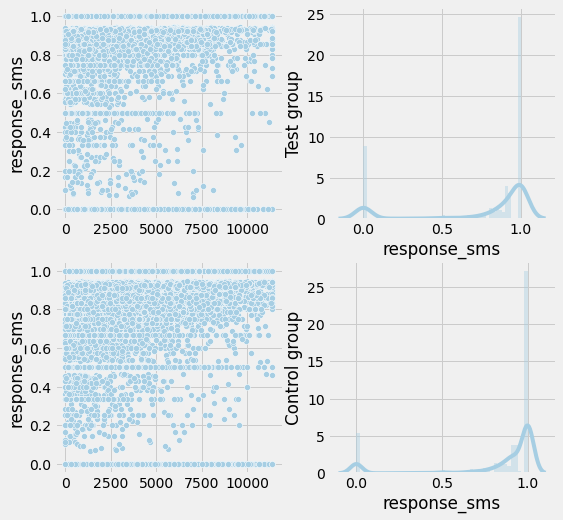

In [29]:
stubborn_test, active_test, stubborn_control, active_control = create_dataset(pdf)

sales_sum = ['sale_sum_3m_g{}'.format(i) for i in [24, 26, 32, 33]]

f, axs = plt.subplots(2, 2, figsize=(8, 8))

sns.scatterplot(active_test[sales_sum].sum(axis=1), active_test['response_sms'], ax=axs[0, 0])
sns.distplot(active_test['response_sms'], ax=axs[0, 1])
axs[0, 1].set_ylabel('Test group')

sns.scatterplot(active_control[sales_sum].sum(axis=1), active_control['response_sms'], ax=axs[1, 0])
sns.distplot(active_control['response_sms'], ax=axs[1, 1])
axs[1, 1].set_ylabel('Control group')
plt.show()

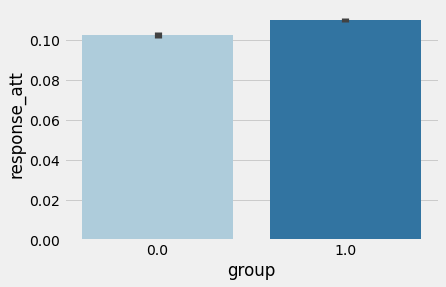

In [30]:
sns.barplot(x = 'group', y='response_att', data=pdf)
plt.show()

In the interaction proportion of customers who completed the target action is 11.01%. Without interaction, 10.25%. So the effect of the mailing increases this share by 0.75%.



## Modeling

There are multiple modeling methods proposed within the past ten years, and the **scikit-uplift** package have several implementaion included. Below we will walk through the provided APIs as well as the intuitions behind.

In [31]:
from sklearn.model_selection import train_test_split
from sklift.models import ClassTransformation
from sklift.viz.base import plot_uplift_by_percentile
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score
from sklearn.base import clone
# from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

In [32]:
drop_cols = ['CardHolder', 'group', 'response_att', 'response_sms', 'response_viber']
try_feat = list(set(pdf.columns.tolist()) - set(drop_cols))

df_tr, df_val = train_test_split(
    pdf, 
    test_size=0.3, 
    stratify=pdf['response_att']
)

X_train, y_train, treat_train = df_tr[try_feat], df_tr['response_att'], df_tr['group']
X_val, y_val, treat_val = df_val[try_feat], df_val['response_att'], df_val['group']

In [33]:
models_results = {
    'approach': [],
    'uplift': []
}

In [34]:
def fit_uplift_models(model, name,  X_train, y_train, treat_train, X_val, y_val, treat_val, k):
    """
    Wrapper function to fit different uplift model.
    """
    model = model.fit(X_train, y_train, treat_train)
    uplift = model.predict(X_val)
    
    score = uplift_at_k(y_true = y_val, uplift = uplift, treatment = treat_val, strategy='overall', k = k)
    models_results['approach'].append(name)
    models_results['uplift'].append(score)
    return model
    

### SoloModel

SoloModel is one of the simplest approach proposed in 2012 SIGKDD conference. In short, what this model does is to fit the same model on two different dataset, one with treatment and one without. The uplift is calculated by subtracting the results from the two.

<img src='pic/solo.png' width=800>


***Reference***: Lo, Victor. (2002). The True Lift Model - A Novel Data Mining Approach to Response Modeling in Database Marketing. SIGKDD Explorations. 4. 78-86.


Learning rate set to 0.271784
0:	learn: 0.4682798	total: 368ms	remaining: 3m 3s
50:	learn: 0.2798152	total: 10.4s	remaining: 1m 31s
100:	learn: 0.2755539	total: 19.7s	remaining: 1m 17s
150:	learn: 0.2717760	total: 32.2s	remaining: 1m 14s
200:	learn: 0.2682330	total: 44.4s	remaining: 1m 6s
250:	learn: 0.2648758	total: 56.7s	remaining: 56.3s
300:	learn: 0.2616910	total: 1m 7s	remaining: 44.3s
350:	learn: 0.2585800	total: 1m 16s	remaining: 32.6s
400:	learn: 0.2555749	total: 1m 25s	remaining: 21.2s
450:	learn: 0.2527056	total: 1m 35s	remaining: 10.4s
499:	learn: 0.2500334	total: 1m 48s	remaining: 0us


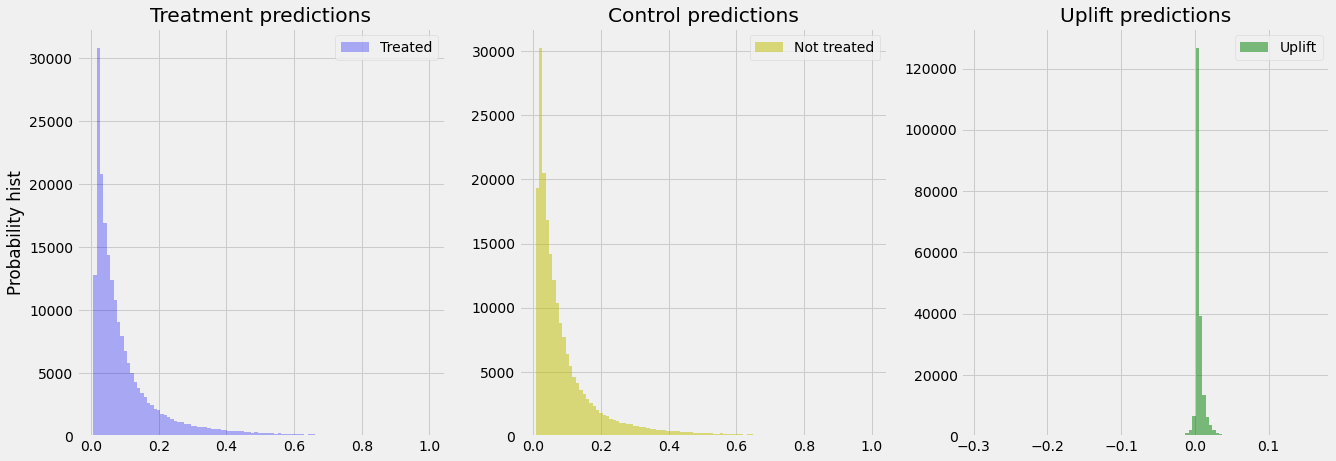

In [35]:
estimator = CatBoostClassifier(iterations=500, verbose=50)
sm = SoloModel(estimator, method = 'dummy')
sm = fit_uplift_models(sm, 'SoloModel_dummy',  X_train, y_train, treat_train, X_val, y_val, treat_val, k=0.3)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_
# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)
plt.show()

Learning rate set to 0.271784
0:	learn: 0.4678071	total: 323ms	remaining: 2m 41s
50:	learn: 0.2800455	total: 18.1s	remaining: 2m 39s
100:	learn: 0.2755993	total: 33.8s	remaining: 2m 13s
150:	learn: 0.2717512	total: 52.5s	remaining: 2m 1s
200:	learn: 0.2680879	total: 1m 13s	remaining: 1m 49s
250:	learn: 0.2646483	total: 1m 38s	remaining: 1m 37s
300:	learn: 0.2613626	total: 2m 5s	remaining: 1m 22s
350:	learn: 0.2581861	total: 2m 23s	remaining: 1m
400:	learn: 0.2552591	total: 2m 38s	remaining: 39.2s
450:	learn: 0.2523360	total: 2m 59s	remaining: 19.5s
499:	learn: 0.2495337	total: 3m 20s	remaining: 0us


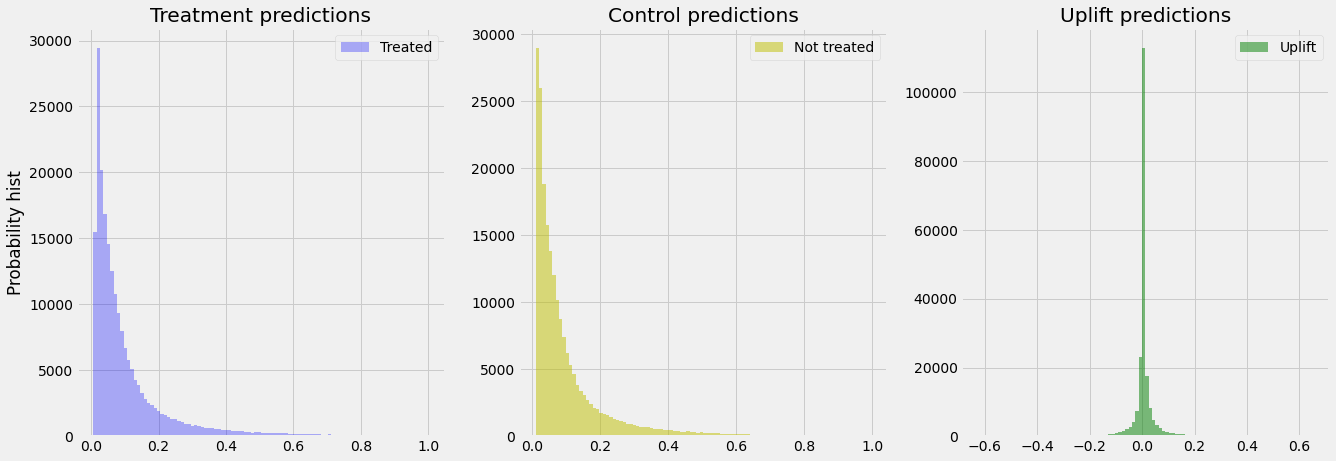

In [36]:
estimator = CatBoostClassifier(iterations=500, verbose=50)
sm = SoloModel(estimator, method = 'treatment_interaction')
sm = fit_uplift_models(sm, 'SoloModel_iteraction',  X_train, y_train, treat_train, X_val, y_val, treat_val, k=0.3)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_
# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)
plt.show()

### Class Transfomation



The modeling technique we will be implementing here is called **ClassTransformation** presented in by Maciej Jaskowski and Szymon Jaroszewicz in 2012 ICML Workshop on Clinical Data Analysis. The gist of ClassTransformation is as below.

$$Z_i = Y_i * W_i + (1 - Y_i) * (1 - W_i)$$

where

* $Z_i$: new target for the i-th customer
* $Y_i$: previous target for the i-th customer
* $W_i$: treatment flag assigned to the i-th customer

That is, 


$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$


***Reference***: Maciej Jaskowski and Szymon Jaroszewicz. Uplift modeling for clinical trial data. ICML Workshop on Clinical Data Analysis, 2012.

In [37]:
estimator = CatBoostClassifier(iterations=500, verbose=50)
ct = ClassTransformation(estimator)
ct = fit_uplift_models(ct, 'ClassTransformation',  X_train, y_train, treat_train, X_val, y_val, treat_val, k=0.3)

Learning rate set to 0.271784
0:	learn: 0.6533282	total: 171ms	remaining: 1m 25s
50:	learn: 0.6054047	total: 13.5s	remaining: 1m 58s
100:	learn: 0.6015504	total: 30s	remaining: 1m 58s
150:	learn: 0.5978219	total: 43.2s	remaining: 1m 39s
200:	learn: 0.5942932	total: 57.7s	remaining: 1m 25s
250:	learn: 0.5908440	total: 1m 8s	remaining: 1m 7s
300:	learn: 0.5876143	total: 1m 19s	remaining: 52.6s
350:	learn: 0.5844391	total: 1m 32s	remaining: 39.3s
400:	learn: 0.5813717	total: 1m 46s	remaining: 26.2s
450:	learn: 0.5784049	total: 2m 5s	remaining: 13.7s
499:	learn: 0.5755348	total: 2m 17s	remaining: 0us


## TwoModels

The two models approach is the most widely used approach and can often be seen in recent research papers. There are two main kinds of **TwoModels** approaches -- ***independent*** and ***dependent***.


### Independent TwoModels
The main idea of this structure is to estimate conditional probabilities of the treatment and control groups separately. It can be summarized as the steps below.


1. Train the ***first model*** using the treatment set.

2. Train the ***second model*** using the control set.

3. Subtract the control model scores from the treatment model scores to get uplift.


<img src='pic/two_ind.png' width=800>

---

### Dependent TwoModels

The idea is that if there are $L$ different labels, you can build $L$ different classifiers. Each classifier should work on binary classification problem respectively, and in the learning process each subsequent classifier uses the predictions of the previous ones as additional features. 

Bearing this chain method in mind, the authors of this method proposed to use the same idea to solve the problem of uplift modeling ***in two stages***.

<img src='pic/two_d.png' width=800>

Learning rate set to 0.150011
0:	learn: 0.5503903	total: 74.5ms	remaining: 37.2s
100:	learn: 0.2579366	total: 6.64s	remaining: 26.3s
200:	learn: 0.2430476	total: 15s	remaining: 22.2s
300:	learn: 0.2301744	total: 25s	remaining: 16.5s
400:	learn: 0.2187220	total: 34s	remaining: 8.38s
499:	learn: 0.2086935	total: 39.8s	remaining: 0us
Learning rate set to 0.240555
0:	learn: 0.4938855	total: 299ms	remaining: 2m 29s
100:	learn: 0.2788325	total: 15.8s	remaining: 1m 2s
200:	learn: 0.2702028	total: 30.7s	remaining: 45.7s
300:	learn: 0.2625001	total: 46.6s	remaining: 30.8s
400:	learn: 0.2554308	total: 1m 8s	remaining: 17s
499:	learn: 0.2489609	total: 1m 24s	remaining: 0us


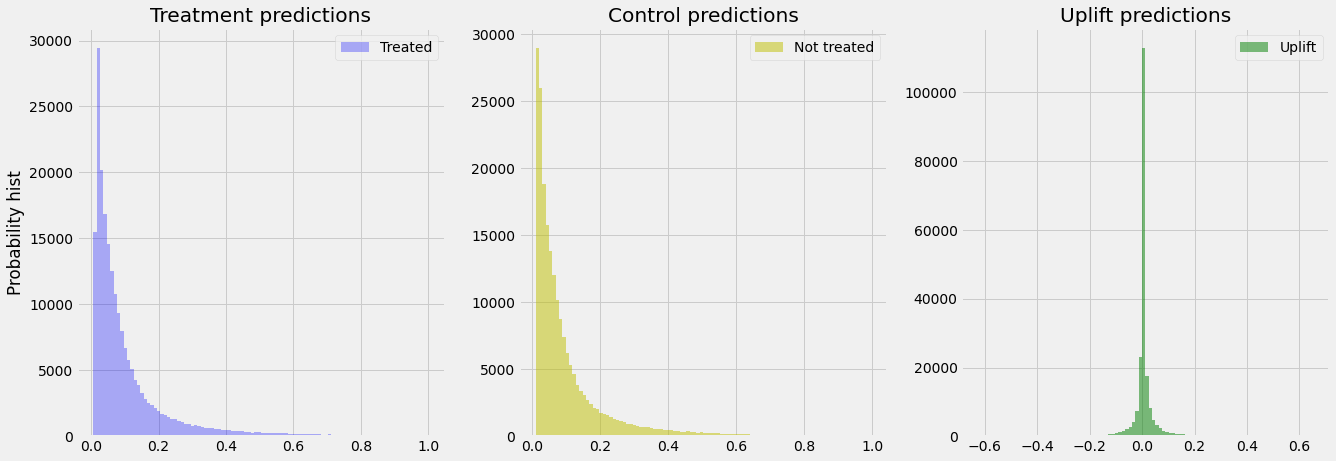

In [38]:
from sklift.models import TwoModels

estimator_trmnt = CatBoostClassifier(iterations=500, verbose=100)
estimator_ctrl = CatBoostClassifier(iterations=500, verbose=100)
tm = TwoModels(estimator_trmnt, estimator_ctrl, method = 'vanilla')
tm = fit_uplift_models(tm, 'TwoModels_vanilla',  X_train, y_train, treat_train, X_val, y_val, treat_val, k=0.3)

tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_
# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)
plt.show()

Learning rate set to 0.150011
0:	learn: 0.5503903	total: 103ms	remaining: 51.4s
100:	learn: 0.2579366	total: 8.62s	remaining: 34.1s
200:	learn: 0.2430476	total: 15.9s	remaining: 23.7s
300:	learn: 0.2301744	total: 23s	remaining: 15.2s
400:	learn: 0.2187220	total: 30.2s	remaining: 7.44s
499:	learn: 0.2086935	total: 36s	remaining: 0us
Learning rate set to 0.240555
0:	learn: 0.4904498	total: 185ms	remaining: 1m 32s
100:	learn: 0.2788357	total: 13.4s	remaining: 52.8s
200:	learn: 0.2702646	total: 31.9s	remaining: 47.5s
300:	learn: 0.2625228	total: 59.1s	remaining: 39.1s
400:	learn: 0.2554508	total: 1m 13s	remaining: 18.1s
499:	learn: 0.2489477	total: 1m 32s	remaining: 0us


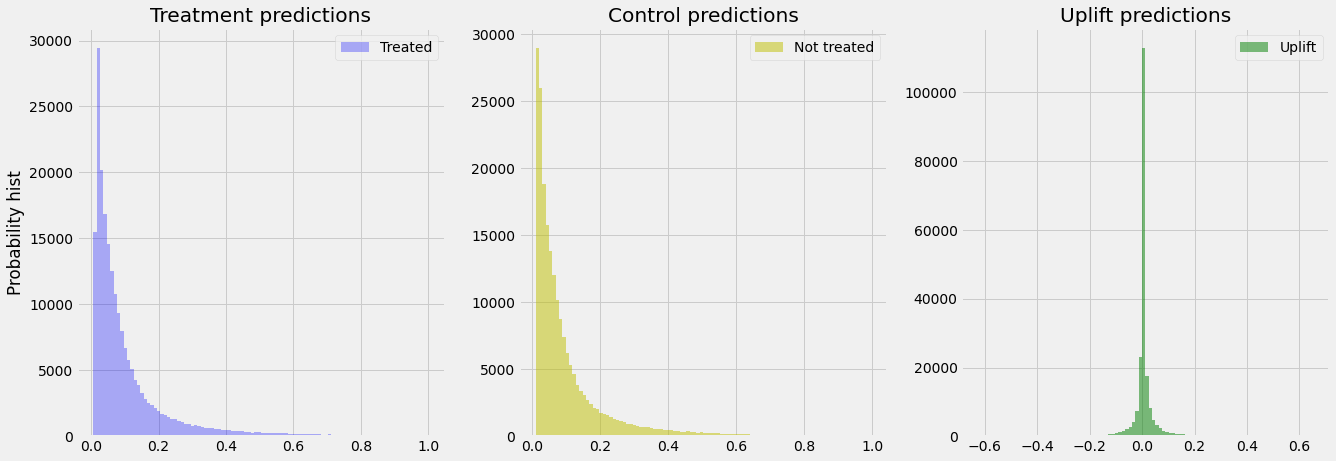

In [39]:
estimator_trmnt = CatBoostClassifier(iterations=500, verbose=100)
estimator_ctrl = CatBoostClassifier(iterations=500, verbose=100)
tm = TwoModels(estimator_trmnt, estimator_ctrl, method = 'ddr_control')
tm = fit_uplift_models(tm, 'TwoModels_ddr_ctrl',  X_train, y_train, treat_train, X_val, y_val, treat_val, k=0.3)

tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_
# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)
plt.show()

Learning rate set to 0.240555
0:	learn: 0.4938855	total: 268ms	remaining: 2m 13s
100:	learn: 0.2788325	total: 21.2s	remaining: 1m 23s
200:	learn: 0.2702028	total: 43.9s	remaining: 1m 5s
300:	learn: 0.2625001	total: 1m 2s	remaining: 41.3s
400:	learn: 0.2554308	total: 1m 27s	remaining: 21.6s
499:	learn: 0.2489609	total: 1m 45s	remaining: 0us
Learning rate set to 0.150011
0:	learn: 0.5488274	total: 67.2ms	remaining: 33.6s
100:	learn: 0.2578252	total: 7.01s	remaining: 27.7s
200:	learn: 0.2428662	total: 14.6s	remaining: 21.7s
300:	learn: 0.2300856	total: 21.6s	remaining: 14.3s
400:	learn: 0.2188899	total: 28.8s	remaining: 7.1s
499:	learn: 0.2085590	total: 35.3s	remaining: 0us


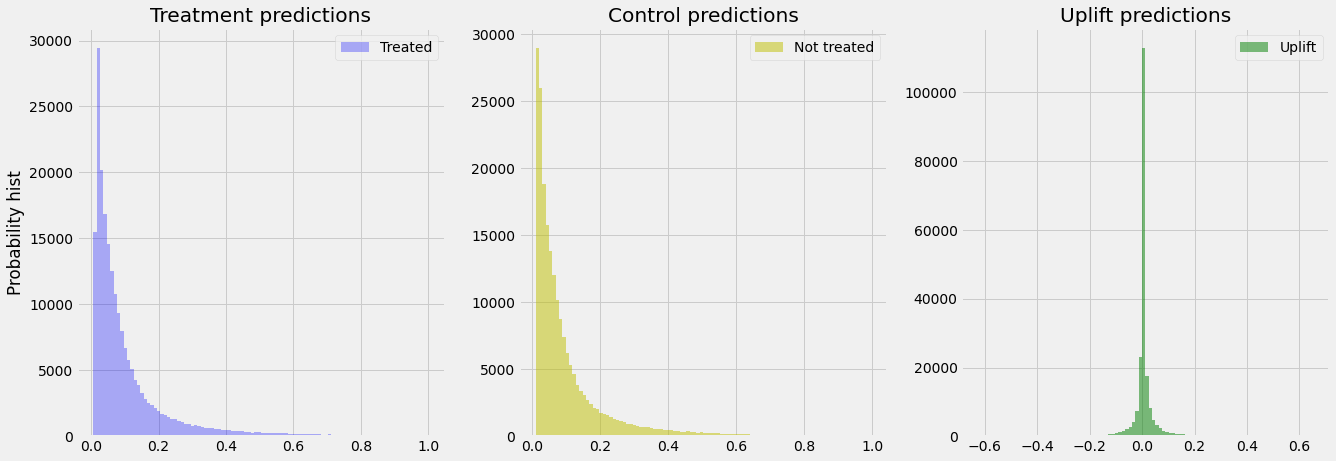

In [40]:
estimator_trmnt = CatBoostClassifier(iterations=500, verbose=100)
estimator_ctrl = CatBoostClassifier(iterations=500, verbose=100)
tm = TwoModels(estimator_trmnt, estimator_ctrl, method = 'ddr_treatment')
tm = fit_uplift_models(tm, 'TwoModels_ddr_trmnt',  X_train, y_train, treat_train, X_val, y_val, treat_val, k=0.3)

tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_
# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)
plt.show()

## Model Commparison

We want to know which model structure best captures the interrelationship between dependent and target variables. 

* To achieve this, we first make a comparison dataframe to see which model is preferred. 

* Thereafter, we will model the entire dataset with preferred model structure to see which variable has the highest effect.

* After figuring out which parameter matters most, we can dig into the variable to see if there's any insight we can find out.

In [41]:
pd.DataFrame(data=models_results).sort_values('uplift', ascending=False)

,approach,uplift
0,SoloModel_dummy,0.010320
2,ClassTransformation,0.009916
5,TwoModels_ddr_trmnt,0.007981
1,SoloModel_iteraction,0.007001
3,TwoModels_vanilla,0.004684
4,TwoModels_ddr_ctrl,0.004477


From the comparison above, we can see that the **`SoloModel structure`** works the best. Thus, we will construct a new model using the SoloModel structure and try to find insights.

In [42]:
estimator = CatBoostClassifier(iterations=1000, verbose=100)
sm = SoloModel(estimator, method = 'dummy')
sm = sm.fit(pdf[try_feat], pdf['response_att'], pdf['group'])

Learning rate set to 0.167619
0:	learn: 0.5403901	total: 410ms	remaining: 6m 49s
100:	learn: 0.2791533	total: 29.9s	remaining: 4m 25s
200:	learn: 0.2752025	total: 58.6s	remaining: 3m 52s
300:	learn: 0.2718122	total: 1m 32s	remaining: 3m 33s
400:	learn: 0.2685859	total: 2m 3s	remaining: 3m 3s
500:	learn: 0.2655975	total: 2m 32s	remaining: 2m 31s
600:	learn: 0.2627308	total: 3m 6s	remaining: 2m 3s
700:	learn: 0.2599061	total: 3m 39s	remaining: 1m 33s
800:	learn: 0.2571693	total: 4m 16s	remaining: 1m 3s
900:	learn: 0.2546012	total: 4m 58s	remaining: 32.8s
999:	learn: 0.2521086	total: 5m 37s	remaining: 0us


In [43]:
sm_full = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_full[:20]

,feature_name,feature_score
0,k_var_days_between_visits_3m,4.966252
1,stdev_days_between_visits_15d,3.415552
2,perdelta_days_between_visits_15_30d,3.186242
3,k_var_days_between_visits_1m,2.853852
4,food_share_1m,2.761185
5,cheque_count_12m_g48,2.465837
6,k_var_days_between_visits_15d,2.462326
7,stdev_discount_depth_1m,2.047201
8,k_var_sku_price_3m_g27,1.751295
9,months_from_register,1.558989


From the result above, we can see that variables related to **days between visits** has more impact on the result.

## What to do next?
From here we realize that variables such as **`k_var_days_between_visits_3m`** and **`stdev_days_between_visits_15d`** have great impact on the output. We can dive deeper into how these two variables interact with other categorical variables such as demographics. 